<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/OWLv2/Zero_and_one_shot_object_detection_with_OWLv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: zero- and one-shot object detection with OWLv2

In this notebook, we'll play around with [OWLv2](https://huggingface.co/docs/transformers/main/en/model_doc/owlv2), the new version of Google's [OWL-ViT model](https://huggingface.co/docs/transformers/model_doc/owlvit). This model is a minimal modification of OpenAI's [CLIP](https://huggingface.co/docs/transformers/model_doc/clip) model to do zero-shot object detection (meaning, detecting objects in an image without every being trained explicitly with manually drawn bounding boxes). This is awesome since usually, for having a good object detector, one needs to collect a dataset of manually drawn bounding boxes, which is a very boring task!

## Set-up environment

Let's start by installing our favorite library: 🤗 Transformers. We install from Github here as the model is brand new at the time of writing.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 210021, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 210021 (delta 5), reused 10 (delta 5), pack-reused 210007
Receiving objects: 100% (210021/210021), 180.01 MiB | 15.25 MiB/s, done.
Resolving deltas: 100% (157565/157565), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.7 MB/s eta 0:00:00


## Load model and processor

Next, we load an OWLv2 checkpoint from the [hub](https://huggingface.co/models?other=owlv2). Note that the authors released several, with various patch sizes, and training schemes (self-trained only, self-trained + fine-tuned, and an ensemble). We'll load an ensemble checkpoint here since it performs best. Note that the authors also did release larger checkpoints, which have even better performance.

In [2]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load image

Next, let's load an image on which we'd like to detect some objects.

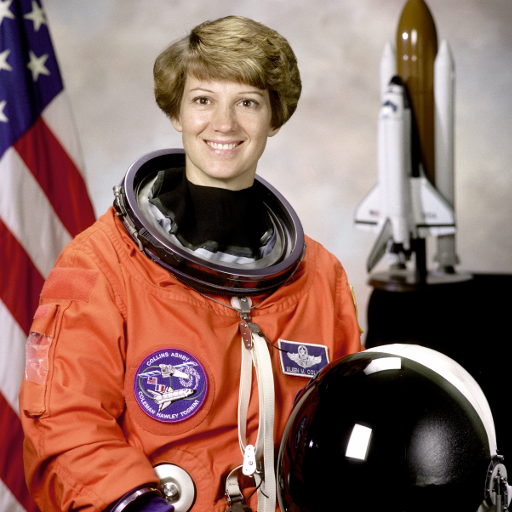

In [3]:
from huggingface_hub import hf_hub_download
from PIL import Image

filepath = hf_hub_download(repo_id="adirik/OWL-ViT", repo_type="space", filename="assets/astronaut.png")
image = Image.open(filepath)
image

## Prepare image and queries for the model

OWLv2 (which uses the same architecture as OWL-ViT) is capable of detecting objects given text queries. Hence we'll define some texts which the model can detect. We can prepare the image and the texts for the model using the processor:

In [4]:
texts = [['face', 'rocket', 'nasa badge', 'star-spangled banner']]
inputs = processor(text=texts, images=image, return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([4, 16])
attention_mask torch.Size([4, 16])
pixel_values torch.Size([1, 3, 960, 960])


## Forward pass

Forwarding the inputs through the model is just a single line of code! We'll also use the `with torch_no_grad()` context manager here to reduce memory (we don't need gradients to be computed/stored at inference time).

In [10]:
import torch

with torch.no_grad():
  outputs = model(**inputs)

## Visualize results

Finally let's plot the results!

In [11]:
# Convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.2)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected rocket with confidence 0.225 at location [429.96, 40.94, 458.24, 260.62]
Detected star-spangled banner with confidence 0.452 at location [1.29, -1.43, 99.17, 505.05]
Detected rocket with confidence 0.292 at location [352.95, 26.99, 465.02, 288.64]
Detected star-spangled banner with confidence 0.21 at location [7.6, 0.98, 512.75, 506.5]
Detected nasa badge with confidence 0.205 at location [23.5, 330.79, 52.14, 384.63]
Detected nasa badge with confidence 0.513 at location [278.26, 339.86, 329.93, 378.28]
Detected nasa badge with confidence 0.601 at location [132.39, 348.03, 208.62, 423.58]


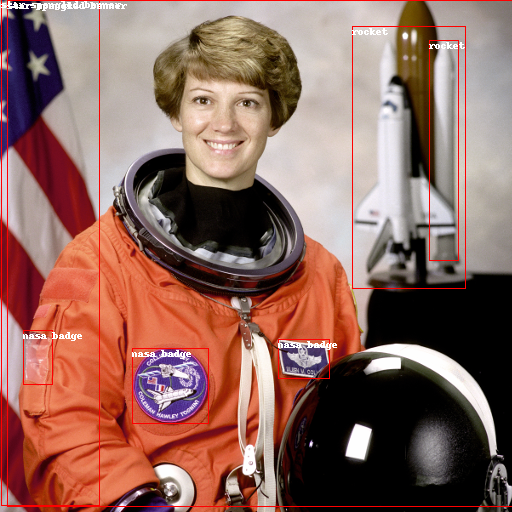

In [12]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    x1, y1, x2, y2 = tuple(box)
    draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
    draw.text(xy=(x1, y1), text=text[label])

image

## Bonus: image-guided (one-shot) object detection

Similar to OWL-ViT v1, the model is also able to perform object detection based on a single query image. This means that we can detect cats in a new image based on an example image of a cat, for instance.

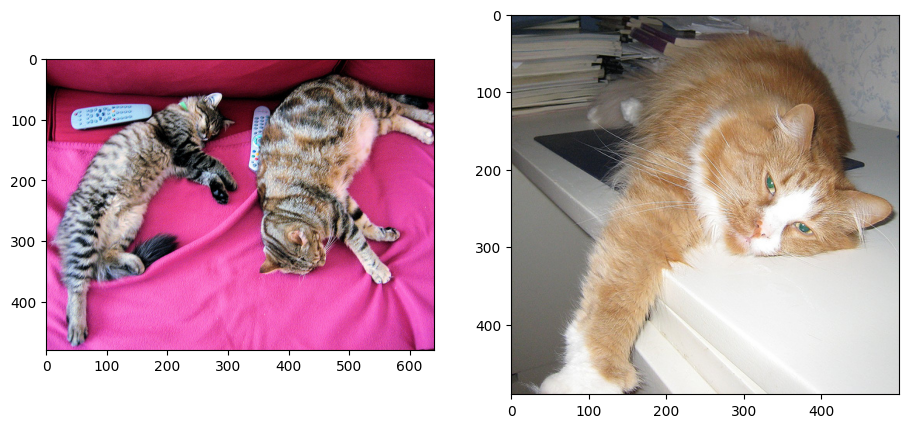

In [13]:
import cv2
from PIL import Image
import requests
import torch
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Set figure size
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8

# Input image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
target_sizes = torch.Tensor([image.size[::-1]])

# Query image
query_url = "http://images.cocodataset.org/val2017/000000058111.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

# Display input image and query image
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(query_image)

To prepare the query image for the model, we need to pass it to the preprocessor.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Process input and query image
inputs = processor(images=image, query_images=query_image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 960, 960])
pixel_values: torch.Size([1, 3, 960, 960])


Next, we can call the image_guided_detection method on the model.

In [16]:
# Get predictions
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 3600, 1])
image_embeds: shape of torch.Size([1, 60, 60, 768])
query_image_embeds: shape of torch.Size([1, 60, 60, 768])
target_pred_boxes: shape of torch.Size([1, 3600, 4])
query_pred_boxes: shape of torch.Size([1, 3600, 4])
class_embeds: shape of torch.Size([1, 3600, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 3601, 768])
pooler_output: shape of torch.Size([1, 768])


Let's visualize the results! Note that the model is a bit sensitive to the threshold values.

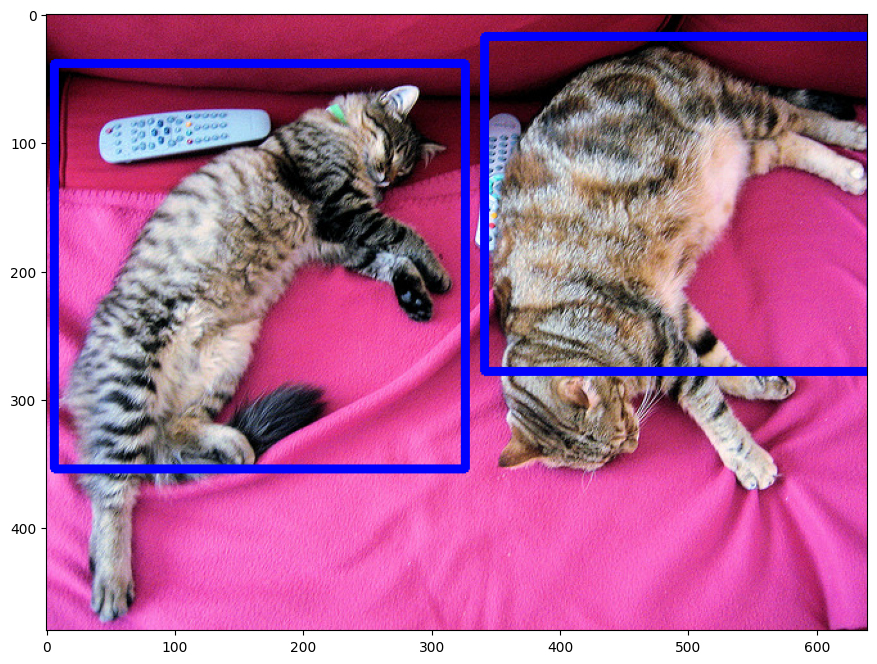

In [21]:
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.9, nms_threshold=0.3, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw predicted bounding boxes
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255,0,0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25

plt.imshow(img[:,:,::-1])